In [ ]:
# conda install -c conda-forge spacy


In [ ]:
# !python -m spacy download en

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
import pickle
from collections import Counter
import spacy
from spacy import displacy
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

In [2]:
train_triplet_to_text = pd.read_csv('train_triplet_to_text.csv')
train_triplet_to_text.head()

,input_text,target_text
0,"Allen_Forrest | birthPlace | ""Fort Campbell, K...","Allen Forrest was born in Fort Campbell, KY an..."
1,Akron_Summit_Assault | ground | St._Vincent–St...,The ground of Akron Summit Assault is in St Vi...
2,Addis_Ababa_City_Hall | buildingStartDate | 19...,The Addis Ababa City Hall was built in 1961 an...
3,ALCO_RS-3 | builder | Montreal_Locomotive_Work...,The ALCO RS-3 has a V12 engine and is 17068.8 ...
4,Atlantic_City_International_Airport | operatin...,"The Port Authority of New York and New Jersey,..."


In [3]:
train_triplet_to_text["target_text"]

0       Allen Forrest was born in Fort Campbell, KY an...
1       The ground of Akron Summit Assault is in St Vi...
2       The Addis Ababa City Hall was built in 1961 an...
3       The ALCO RS-3 has a V12 engine and is 17068.8 ...
4       The Port Authority of New York and New Jersey,...
                              ...                        
2187    Bhajji comes from the country India, where Nar...
2188        William Anders was born in British Hong Kong.
2189    Pierce County, Washington is located within th...
2190    The 14th New Jersey Volunteer Infantry Monumen...
2191                                                  NaN
Name: target_text, Length: 2192, dtype: object

In [4]:
text_to_tuples_dict = {}
for idx,row in train_triplet_to_text.iterrows():
    text_to_tuples_dict[row['target_text']] = row['input_text'].split("&&")

In [5]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text  = str(text)
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [6]:
master_dict = {} 
# dictionary format -- {text : {split_sentences: [ ] , tuples : []}}
for text in tqdm(list(text_to_tuples_dict.keys()), position = 0, desc = "Progress"):
    
    split_sentences = split_into_sentences(text)
    tuples = text_to_tuples_dict[text]
    master_dict[text] = {'split_sentences': split_sentences,
                        'tuples' : tuples}

Progress: 100%|██████████████████████████| 2186/2186 [00:00<00:00, 39671.97it/s]


In [7]:
master_dict[list(master_dict.keys())[0]]

{'split_sentences': ['Allen Forrest was born in Fort Campbell, KY and was raised in Dothan, AL.'],
 'tuples': ['Allen_Forrest | birthPlace | "Fort Campbell, KY, raised in Dothan, AL"']}

In [8]:
from pathlib import Path

def show_dependency_graph(doc, save_file = False):
    print ("{:<15} | {:<8} | {:<15} | {:<20}".format('Token','Relation','Head', 'Children'))
    print ("-" * 70)

    for token in doc:
      # Print the token, dependency nature, head and all dependents of the token
      print ("{:<15} | {:<8} | {:<15} | {:<20}"
             .format(str(token.text), str(token.dep_), str(token.head.text), str([child for child in token.children])))

     # Use displayCy to visualize the dependency 
    img = displacy.render(doc, style='dep', jupyter=True, options={'distance': 100})
    if save_file:
        output_path = Path("dependency_plot.svg") # you can keep there only "dependency_plot.svg" if you want to save it in the same folder where you run the script 
        output_path.open("w", encoding="utf-8").write(img)
    
    




In [9]:
nlp = spacy.load("en_core_web_sm")

for key in tqdm(list(master_dict.keys()), position = 0, desc = "Progress : "):
    
    split_sentences = master_dict[key]['split_sentences']
    dependency_relations = []
    for sentence in split_sentences:
        doc = nlp(sentence)
        dependency_relations_sentence = [doc]
        for token in doc:
            dep_dict = {}
            text = token.text
            Relation = token.dep_
            Head = token.head.text
            Children = [child for child in token.children]
#             print(text, Relation , Head, Children)
            dep_dict['text'] = text
            dep_dict['Relation'] = Relation
            dep_dict['Head'] = Head
            dep_dict['Children'] = Children
            dependency_relations_sentence.append(dep_dict)
        dependency_relations.append(dependency_relations_sentence)
    master_dict[key]['dependency_relations'] = dependency_relations
        
#         show_dependency_graph(doc)
        
    
        

Progress : 100%|████████████████████████████| 2186/2186 [00:28<00:00, 76.05it/s]


In [10]:
sample_idx = 1
master_dict[list(master_dict.keys())[sample_idx]]['dependency_relations']

[[The ground of Akron Summit Assault is in St Vincent St Mary High School of Akron, Ohio.,
  {'text': 'The', 'Relation': 'det', 'Head': 'ground', 'Children': []},
  {'text': 'ground', 'Relation': 'nsubj', 'Head': 'is', 'Children': [The, of]},
  {'text': 'of', 'Relation': 'prep', 'Head': 'ground', 'Children': [Assault]},
  {'text': 'Akron', 'Relation': 'compound', 'Head': 'Assault', 'Children': []},
  {'text': 'Summit',
   'Relation': 'compound',
   'Head': 'Assault',
   'Children': []},
  {'text': 'Assault',
   'Relation': 'pobj',
   'Head': 'of',
   'Children': [Akron, Summit]},
  {'text': 'is',
   'Relation': 'ROOT',
   'Head': 'is',
   'Children': [ground, in, .]},
  {'text': 'in', 'Relation': 'prep', 'Head': 'is', 'Children': [School]},
  {'text': 'St', 'Relation': 'compound', 'Head': 'School', 'Children': []},
  {'text': 'Vincent',
   'Relation': 'compound',
   'Head': 'School',
   'Children': []},
  {'text': 'St', 'Relation': 'compound', 'Head': 'School', 'Children': []},
  {'tex

In [11]:
show_dependency_graph(master_dict[list(master_dict.keys())[sample_idx]]['dependency_relations'][0][0],save_file=False)

Token           | Relation | Head            | Children            
----------------------------------------------------------------------
The             | det      | ground          | []                  
ground          | nsubj    | is              | [The, of]           
of              | prep     | ground          | [Assault]           
Akron           | compound | Assault         | []                  
Summit          | compound | Assault         | []                  
Assault         | pobj     | of              | [Akron, Summit]     
is              | ROOT     | is              | [ground, in, .]     
in              | prep     | is              | [School]            
St              | compound | School          | []                  
Vincent         | compound | School          | []                  
St              | compound | School          | []                  
Mary            | compound | School          | []                  
High            | compound | School          

# Clustering Test on random sentences

In [11]:
# conda install -c conda-forge sentence-transformers 

In [12]:
# !pip install sentence-transformers

In [13]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dakshthapar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [48]:
sentences = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'A man is eating pasta.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.'
            ]

# Tokenization of each document
tokenized_sent = []
for s in sentences:
    tokenized_sent.append(word_tokenize(s.lower()))
tokenized_sent

[['a', 'man', 'is', 'eating', 'food', '.'],
 ['a', 'man', 'is', 'eating', 'a', 'piece', 'of', 'bread', '.'],
 ['a', 'man', 'is', 'eating', 'pasta', '.'],
 ['the', 'girl', 'is', 'carrying', 'a', 'baby', '.'],
 ['the', 'baby', 'is', 'carried', 'by', 'the', 'woman'],
 ['a', 'man', 'is', 'riding', 'a', 'horse', '.'],
 ['a',
  'man',
  'is',
  'riding',
  'a',
  'white',
  'horse',
  'on',
  'an',
  'enclosed',
  'ground',
  '.'],
 ['a', 'monkey', 'is', 'playing', 'drums', '.'],
 ['someone',
  'in',
  'a',
  'gorilla',
  'costume',
  'is',
  'playing',
  'a',
  'set',
  'of',
  'drums',
  '.'],
 ['a', 'cheetah', 'is', 'running', 'behind', 'its', 'prey', '.'],
 ['a', 'cheetah', 'chases', 'prey', 'on', 'across', 'a', 'field', '.']]

In [49]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [50]:
sentence_embeddings = sbert_model.encode(sentences)
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

Sample BERT embedding vector - length 768
Sample BERT embedding vector - note includes negative values [ 1.66185856e-01  1.24404050e-01  1.24970782e+00 -5.38381338e-01
 -3.13073874e-01  7.52459943e-01 -1.24883103e+00  6.87136710e-01
 -6.58801079e-01 -7.94196248e-01 -1.28960490e-01  8.81197035e-01
 -2.20511675e-01  2.43561834e-01  8.58891726e-01 -3.24881524e-01
  7.66353905e-02 -9.61474657e-01  4.37114149e-01 -2.51154125e-01
 -1.76504776e-01  1.66995853e-01 -9.16695714e-01 -9.06207025e-01
 -1.71470433e-01  2.67859310e-01 -8.09518278e-01  4.01738793e-01
  7.96617806e-01  2.13668600e-01 -1.09779611e-01  3.62069249e-01
  4.81450170e-01 -5.60663581e-01 -1.60017252e+00 -7.52470613e-01
  9.44361567e-01 -3.59769426e-02  2.05376714e-01  1.24123728e+00
  1.22481123e-01  3.00850153e-01  1.50590867e-01  9.87002969e-01
  6.19929075e-01 -2.87815124e-01  1.41617095e+00  9.16837811e-01
  1.05796112e-02 -1.01104403e+00  1.31013250e+00 -1.11828232e+00
 -1.11743903e+00  5.88853620e-02 -6.34345829e-01  1.

In [51]:
len(sentence_embeddings), sentence_embeddings.shape

(11, (11, 768))

In [52]:
# Perform kmean clustering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['The girl is carrying a baby.', 'The baby is carried by the woman']

Cluster  2
['A monkey is playing drums.', 'Someone in a gorilla costume is playing a set of drums.']

Cluster  3
['A man is eating food.', 'A man is eating a piece of bread.', 'A man is eating pasta.']

Cluster  4
['A cheetah is running behind its prey.', 'A cheetah chases prey on across a field.']

Cluster  5
['A man is riding a horse.', 'A man is riding a white horse on an enclosed ground.']



# Clustering Test on WebNLG data


In [93]:
sentences=list(train_triplet_to_text["target_text"])

# Tokenizaton of each document
tokenized_sent = []
for s in tqdm(sentences):
    try:
        tokenized_sent.append(word_tokenize(s.lower()))
    except:
        pass
sentence_embeddings = sbert_model.encode(sentences)
print(len(sentence_embeddings), sentence_embeddings.shape)


num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

100%|█████████████████████████████████████| 2192/2192 [00:00<00:00, 6845.78it/s]


2192 (2192, 768)
Cluster  1
['Allen Forrest was born in Fort Campbell, KY and was raised in Dothan, AL.', 'The ground of Akron Summit Assault is in St Vincent St Mary High School of Akron, Ohio.', 'Elliot See was born in Dallas on July 23, 1927. He graduated from University of Texas at Austin, and competed in the Big 12 Conference.', '101 Helena was discovered by James Craig Watson who originated from Canada and graduated from the University of Michigan.', 'Canadian born, Aaron Boogaard, whose club is Wichita Thunder, was born in 1986 and is 1.905m tall.', '200 Public Square is located in Cleveland whose governing body is Cleveland City Council.', 'Alfred Garth Jones was born in Manchester, England, and died in London. The Labour Party (UK) is the leader of Manchester.', 'Bananaman starred Tim Brooke-Taylor and was first broadcast by STV on 3 October 1983.', 'Ahmet Ertegun died in the U.S.', 'William Anders is a US national who was born in British Hong Kong on 17 October 1933 and retir

In [94]:
cluster_assignment

array([0, 0, 2, ..., 8, 0, 8], dtype=int32)

In [95]:
type(sentence_embeddings),sentence_embeddings.shape

(numpy.ndarray, (2192, 768))

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

S = StandardScaler().fit_transform(sentence_embeddings)
principalComponents = pca.fit_transform(S)
principalComponents.shape

(2192, 2)

In [97]:
principalComponents[:5]

array([[  0.72290784,   0.7810425 ],
       [ -4.403596  ,  -2.5683718 ],
       [-11.6112    ,  -8.018852  ],
       [ -5.300025  ,  -1.2845069 ],
       [ -3.9943032 ,  -5.4866886 ]], dtype=float32)

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

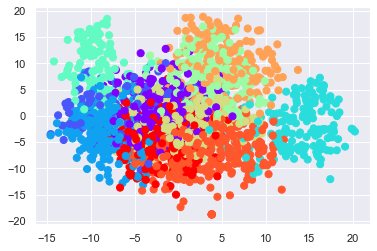

In [114]:
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=cluster_assignment, s=50, cmap='rainbow')
# plt.legend()
centers = clustering_model.cluster_centers_

In [105]:
len(centers)

10